# Imports

In [1]:
from math import ceil
import json
import os
import sys

src_path = os.path.join(os.path.dirname(os.path.abspath('')), 'src')
sys.path.append(src_path)

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve, classification_report
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import visdom

from datasets import link_prediction
from layers import MeanAggregator, LSTMAggregator, MaxPoolAggregator, MeanPoolAggregator
import models
import utils

%load_ext autoreload
%autoreload 2

%matplotlib inline

# Set up arguments for datasets, models and training.

In [2]:
args = {
    "task" : "link_prediction",
    
    "dataset" : "IARadoslawEmail",
    "dataset_path" : "/Users/raunak/Documents/Datasets/temporal-networks-network-repository/ia-radoslaw-email/ia-radoslaw-email.edges",
    "mode" : "train",
    "generate_neg_examples" : True,
    
    "duplicate_examples" : True,
    "repeat_examples" : False,
    
    "self_loop" : False,
    "normalize_adj" : False,
    
    "cuda" : "True",
    "model" : "GraphSAGE",
    "agg_class" : "MaxPoolAggregator",
    "hidden_dims" : [64],
    "dropout" : 0.5,
    "num_samples" : -1,
    
    "epochs" : 3,
    "batch_size" : 32,
    "lr" : 1e-4,
    "weight_decay" : 5e-4,
    "stats_per_batch" : 3,
    "visdom" : True,
    
    "load" : False,
    "save" : False
}
config = args
config['num_layers'] = len(config['hidden_dims']) + 1


if config['cuda'] and torch.cuda.is_available():
    device = 'cuda:0'
else:
    device = 'cpu'
config['device'] = device

# Get the dataset, dataloader and model.

In [3]:
dataset_args = (config['task'], config['dataset'], config['dataset_path'],
                config['generate_neg_examples'], 'train',
                config['duplicate_examples'], config['repeat_examples'],
                config['num_layers'], config['self_loop'],
                config['normalize_adj'])
dataset = utils.get_dataset(dataset_args)

--------------------------------
Reading dataset from /Users/raunak/Documents/Datasets/temporal-networks-network-repository/ia-radoslaw-email/ia-radoslaw-email.edges
Finished reading data.
Setting up graph.
Finished setting up graph.
Setting up examples.
Finished setting up examples.
Dataset properties:
Mode: train
Number of vertices: 167
Number of static edges: 3935
Number of temporal edges: 24878
Number of examples/datapoints: 23028
--------------------------------


In [4]:
loader = DataLoader(dataset=dataset, batch_size=config['batch_size'],
                    shuffle=True, collate_fn=dataset.collate_wrapper)
input_dim, output_dim = dataset.get_dims()
config['input_dim'], config['output_dim'] = input_dim, output_dim

In [5]:
model = utils.get_model(config)
print(model)

GraphSAGE(
  (aggregators): ModuleList(
    (0): MaxPoolAggregator(
      (fc1): Linear(in_features=167, out_features=167, bias=True)
      (relu): ReLU()
    )
    (1): MaxPoolAggregator(
      (fc1): Linear(in_features=64, out_features=64, bias=True)
      (relu): ReLU()
    )
  )
  (fcs): ModuleList(
    (0): Linear(in_features=334, out_features=64, bias=True)
    (1): Linear(in_features=128, out_features=1, bias=True)
  )
  (bns): ModuleList(
    (0): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (dropout): Dropout(p=0.5)
  (relu): ReLU()
)


# Compute ROC-AUC score for the untrained model.

In [6]:
if not config['load']:
    print('--------------------------------')
    print('Computing ROC-AUC score for the training dataset before training.')
    y_true, y_scores = [], []
    num_batches = int(ceil(len(dataset) / config['batch_size']))
    with torch.no_grad():
        for (idx, batch) in enumerate(loader):
            edges, features, node_layers, mappings, rows, labels = batch
            features, labels = features.to(device), labels.to(device)
            out = model(features, node_layers, mappings, rows)
            all_pairs = torch.mm(out, out.t())
            scores = all_pairs[edges.T]
            y_true.extend(labels.detach().numpy())
            y_scores.extend(scores.detach().numpy())
            print('    Batch {} / {}'.format(idx+1, num_batches))
    y_true = np.array(y_true).flatten()
    y_scores = np.array(y_scores).flatten()
    area = roc_auc_score(y_true, y_scores)
    print('ROC-AUC score: {:.4f}'.format(area))
    print('--------------------------------')

--------------------------------
Computing ROC-AUC score for the training dataset before training.
    Batch 1 / 720
    Batch 2 / 720
    Batch 3 / 720
    Batch 4 / 720
    Batch 5 / 720
    Batch 6 / 720
    Batch 7 / 720
    Batch 8 / 720
    Batch 9 / 720
    Batch 10 / 720
    Batch 11 / 720
    Batch 12 / 720
    Batch 13 / 720
    Batch 14 / 720
    Batch 15 / 720
    Batch 16 / 720
    Batch 17 / 720
    Batch 18 / 720
    Batch 19 / 720
    Batch 20 / 720
    Batch 21 / 720
    Batch 22 / 720
    Batch 23 / 720
    Batch 24 / 720
    Batch 25 / 720
    Batch 26 / 720
    Batch 27 / 720
    Batch 28 / 720
    Batch 29 / 720
    Batch 30 / 720
    Batch 31 / 720
    Batch 32 / 720
    Batch 33 / 720
    Batch 34 / 720
    Batch 35 / 720
    Batch 36 / 720
    Batch 37 / 720
    Batch 38 / 720
    Batch 39 / 720
    Batch 40 / 720
    Batch 41 / 720
    Batch 42 / 720
    Batch 43 / 720
    Batch 44 / 720
    Batch 45 / 720
    Batch 46 / 720
    Batch 47 / 720
    Batch 48 / 72

    Batch 417 / 720
    Batch 418 / 720
    Batch 419 / 720
    Batch 420 / 720
    Batch 421 / 720
    Batch 422 / 720
    Batch 423 / 720
    Batch 424 / 720
    Batch 425 / 720
    Batch 426 / 720
    Batch 427 / 720
    Batch 428 / 720
    Batch 429 / 720
    Batch 430 / 720
    Batch 431 / 720
    Batch 432 / 720
    Batch 433 / 720
    Batch 434 / 720
    Batch 435 / 720
    Batch 436 / 720
    Batch 437 / 720
    Batch 438 / 720
    Batch 439 / 720
    Batch 440 / 720
    Batch 441 / 720
    Batch 442 / 720
    Batch 443 / 720
    Batch 444 / 720
    Batch 445 / 720
    Batch 446 / 720
    Batch 447 / 720
    Batch 448 / 720
    Batch 449 / 720
    Batch 450 / 720
    Batch 451 / 720
    Batch 452 / 720
    Batch 453 / 720
    Batch 454 / 720
    Batch 455 / 720
    Batch 456 / 720
    Batch 457 / 720
    Batch 458 / 720
    Batch 459 / 720
    Batch 460 / 720
    Batch 461 / 720
    Batch 462 / 720
    Batch 463 / 720
    Batch 464 / 720
    Batch 465 / 720
    Batch 466 / 720


# Train.

In [7]:
if not config['load']:
    use_visdom = config['visdom']
    if use_visdom:
        vis = visdom.Visdom()
        loss_window = None
    criterion = utils.get_criterion(config['task'])
    optimizer = optim.Adam(model.parameters(), lr=config['lr'],
                           weight_decay=config['weight_decay'])
    epochs = config['epochs']
    stats_per_batch = config['stats_per_batch']
    num_batches = int(ceil(len(dataset) / config['batch_size']))
    # scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=150, gamma=0.8)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100, 500, 1000], gamma=0.7)
    model.train()
    print('--------------------------------')
    print('Training.')
    for epoch in range(epochs):
        print('Epoch {} / {}'.format(epoch+1, epochs))
        running_loss = 0.0
        for (idx, batch) in enumerate(loader):
            edges, features, node_layers, mappings, rows, labels = batch
            features, labels = features.to(device), labels.to(device)
            optimizer.zero_grad()
            out = model(features, node_layers, mappings, rows)
            all_pairs = torch.mm(out, out.t())
            scores = all_pairs[edges.T]
            loss = criterion(scores, labels.float())
            loss.backward()
            optimizer.step()
            with torch.no_grad():
                running_loss += loss.item()
            if (idx + 1) % stats_per_batch == 0:
                running_loss /= stats_per_batch
                print('    Batch {} / {}: loss {:.4f}'.format(
                    idx+1, num_batches, running_loss))
                if (torch.sum(labels.long() == 0).item() > 0) and (torch.sum(labels.long() == 1).item() > 0):
                    area = roc_auc_score(labels.detach().numpy(), scores.detach().numpy())
                    print('    ROC-AUC score: {:.4f}'.format(area))
                running_loss = 0.0
                num_correct, num_examples = 0, 0
            if use_visdom:
                if loss_window is None:
                    loss_window = vis.line(
                        Y=[loss.item()],
                        X=[epoch*num_batches+idx],
                        opts=dict(xlabel='batch', ylabel='Loss', title='Training Loss', legend=['Loss']))
                else:
                    vis.line(
                        [loss.item()],
                        [epoch*num_batches+idx],
                        win=loss_window,
                        update='append')
            scheduler.step()
    if use_visdom:
        vis.close(win=loss_window)
    print('Finished training.')
    print('--------------------------------')

--------------------------------
Training.
Epoch 1 / 3
    Batch 3 / 720: loss 0.6908
    ROC-AUC score: 0.7206
    Batch 6 / 720: loss 0.6906
    ROC-AUC score: 0.8000
    Batch 9 / 720: loss 0.6921
    ROC-AUC score: 0.8000
    Batch 12 / 720: loss 0.6910
    ROC-AUC score: 0.8667
    Batch 15 / 720: loss 0.6901
    ROC-AUC score: 0.7738
    Batch 18 / 720: loss 0.6894
    ROC-AUC score: 0.6761
    Batch 21 / 720: loss 0.6864
    ROC-AUC score: 0.8730
    Batch 24 / 720: loss 0.6842
    ROC-AUC score: 0.6944
    Batch 27 / 720: loss 0.6885
    ROC-AUC score: 0.8750
    Batch 30 / 720: loss 0.6856
    ROC-AUC score: 0.8125
    Batch 33 / 720: loss 0.6810
    ROC-AUC score: 0.8118
    Batch 36 / 720: loss 0.6809
    ROC-AUC score: 0.7368
    Batch 39 / 720: loss 0.6835
    ROC-AUC score: 0.8314
    Batch 42 / 720: loss 0.6792
    ROC-AUC score: 0.9453
    Batch 45 / 720: loss 0.6804
    ROC-AUC score: 0.9190
    Batch 48 / 720: loss 0.6795
    ROC-AUC score: 0.8941
    Batch 51 / 720: 

    Batch 420 / 720: loss 0.5713
    ROC-AUC score: 0.9023
    Batch 423 / 720: loss 0.5670
    ROC-AUC score: 0.9757
    Batch 426 / 720: loss 0.5938
    ROC-AUC score: 0.9500
    Batch 429 / 720: loss 0.5792
    ROC-AUC score: 0.8980
    Batch 432 / 720: loss 0.5952
    ROC-AUC score: 0.8039
    Batch 435 / 720: loss 0.5467
    ROC-AUC score: 0.9913
    Batch 438 / 720: loss 0.4996
    ROC-AUC score: 0.9307
    Batch 441 / 720: loss 0.5333
    ROC-AUC score: 0.9569
    Batch 444 / 720: loss 0.5170
    ROC-AUC score: 0.9393
    Batch 447 / 720: loss 0.5585
    ROC-AUC score: 0.9333
    Batch 450 / 720: loss 0.6186
    ROC-AUC score: 0.9141
    Batch 453 / 720: loss 0.6600
    ROC-AUC score: 0.8139
    Batch 456 / 720: loss 0.6497
    ROC-AUC score: 0.7375
    Batch 459 / 720: loss 0.5607
    ROC-AUC score: 0.9134
    Batch 462 / 720: loss 0.5462
    ROC-AUC score: 0.9271
    Batch 465 / 720: loss 0.5939
    ROC-AUC score: 0.9412
    Batch 468 / 720: loss 0.6353
    ROC-AUC score: 0.91

    Batch 120 / 720: loss 0.5183
    ROC-AUC score: 0.8792
    Batch 123 / 720: loss 0.5164
    ROC-AUC score: 0.9062
    Batch 126 / 720: loss 0.5083
    ROC-AUC score: 0.8651
    Batch 129 / 720: loss 0.5291
    ROC-AUC score: 0.9020
    Batch 132 / 720: loss 0.5582
    ROC-AUC score: 0.9765
    Batch 135 / 720: loss 0.5346
    ROC-AUC score: 0.8849
    Batch 138 / 720: loss 0.5328
    ROC-AUC score: 0.8235
    Batch 141 / 720: loss 0.5127
    ROC-AUC score: 0.9643
    Batch 144 / 720: loss 0.5210
    ROC-AUC score: 0.9883
    Batch 147 / 720: loss 0.5247
    ROC-AUC score: 0.8906
    Batch 150 / 720: loss 0.5621
    ROC-AUC score: 0.8917
    Batch 153 / 720: loss 0.5289
    ROC-AUC score: 0.9271
    Batch 156 / 720: loss 0.6231
    ROC-AUC score: 0.8627
    Batch 159 / 720: loss 0.5074
    ROC-AUC score: 0.9647
    Batch 162 / 720: loss 0.4941
    ROC-AUC score: 0.9275
    Batch 165 / 720: loss 0.4862
    ROC-AUC score: 0.8941
    Batch 168 / 720: loss 0.5552
    ROC-AUC score: 0.86

KeyboardInterrupt: 

In [8]:
if not config['load']:
    if config['save']:
        print('--------------------------------')
        directory = os.path.join(os.path.dirname(os.getcwd()),
                                'trained_models')
        if not os.path.exists(directory):
            os.makedirs(directory)
        fname = utils.get_fname(config)
        path = os.path.join(directory, fname)
        print('Saving model at {}'.format(path))
        torch.save(model.state_dict(), path)
        print('Finished saving model.')
        print('--------------------------------')

# Compute ROC-AUC score after training.

In [9]:
if not config['load']:
    print('--------------------------------')
    print('Computing ROC-AUC score for the training dataset after training.')
    y_true, y_scores = [], []
    num_batches = int(ceil(len(dataset) / config['batch_size']))
    with torch.no_grad():
        for (idx, batch) in enumerate(loader):
            edges, features, node_layers, mappings, rows, labels = batch
            features, labels = features.to(device), labels.to(device)
            out = model(features, node_layers, mappings, rows)
            all_pairs = torch.mm(out, out.t())
            scores = all_pairs[edges.T]
            y_true.extend(labels.detach().numpy())
            y_scores.extend(scores.detach().numpy())
            print('    Batch {} / {}'.format(idx+1, num_batches))
    y_true = np.array(y_true).flatten()
    y_scores = np.array(y_scores).flatten()
    area = roc_auc_score(y_true, y_scores)
    print('ROC-AUC score: {:.4f}'.format(area))
    print('--------------------------------')


--------------------------------
Computing ROC-AUC score for the training dataset after training.
    Batch 1 / 720
    Batch 2 / 720
    Batch 3 / 720
    Batch 4 / 720
    Batch 5 / 720
    Batch 6 / 720
    Batch 7 / 720
    Batch 8 / 720
    Batch 9 / 720
    Batch 10 / 720
    Batch 11 / 720
    Batch 12 / 720
    Batch 13 / 720
    Batch 14 / 720
    Batch 15 / 720
    Batch 16 / 720
    Batch 17 / 720
    Batch 18 / 720
    Batch 19 / 720
    Batch 20 / 720
    Batch 21 / 720
    Batch 22 / 720
    Batch 23 / 720
    Batch 24 / 720
    Batch 25 / 720
    Batch 26 / 720
    Batch 27 / 720
    Batch 28 / 720
    Batch 29 / 720
    Batch 30 / 720
    Batch 31 / 720
    Batch 32 / 720
    Batch 33 / 720
    Batch 34 / 720
    Batch 35 / 720
    Batch 36 / 720
    Batch 37 / 720
    Batch 38 / 720
    Batch 39 / 720
    Batch 40 / 720
    Batch 41 / 720
    Batch 42 / 720
    Batch 43 / 720
    Batch 44 / 720
    Batch 45 / 720
    Batch 46 / 720
    Batch 47 / 720
    Batch 48 / 720

    Batch 412 / 720
    Batch 413 / 720
    Batch 414 / 720
    Batch 415 / 720
    Batch 416 / 720
    Batch 417 / 720
    Batch 418 / 720
    Batch 419 / 720
    Batch 420 / 720
    Batch 421 / 720
    Batch 422 / 720
    Batch 423 / 720
    Batch 424 / 720
    Batch 425 / 720
    Batch 426 / 720
    Batch 427 / 720
    Batch 428 / 720
    Batch 429 / 720
    Batch 430 / 720
    Batch 431 / 720
    Batch 432 / 720
    Batch 433 / 720
    Batch 434 / 720
    Batch 435 / 720
    Batch 436 / 720
    Batch 437 / 720
    Batch 438 / 720
    Batch 439 / 720
    Batch 440 / 720
    Batch 441 / 720
    Batch 442 / 720
    Batch 443 / 720
    Batch 444 / 720
    Batch 445 / 720
    Batch 446 / 720
    Batch 447 / 720
    Batch 448 / 720
    Batch 449 / 720
    Batch 450 / 720
    Batch 451 / 720
    Batch 452 / 720
    Batch 453 / 720
    Batch 454 / 720
    Batch 455 / 720
    Batch 456 / 720
    Batch 457 / 720
    Batch 458 / 720
    Batch 459 / 720
    Batch 460 / 720
    Batch 461 / 720


# Plot the true positive rate and true negative rate vs threshold.

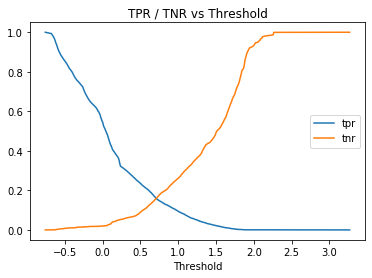

In [10]:
if not config['load']:
    tpr, fpr, thresholds = roc_curve(y_true, y_scores)
    tnr = 1 - fpr
    plt.plot(thresholds, tpr, label='tpr')
    plt.plot(thresholds, tnr, label='tnr')
    plt.xlabel('Threshold')
    plt.title('TPR / TNR vs Threshold')
    plt.legend()

# Choose an appropriate threshold and generate classification report on the train set.

In [11]:
idx1 = np.where(tpr <= tnr)[0]
idx2 = np.where(tpr >= tnr)[0]
t = thresholds[idx1[-1]]
total_correct, total_examples = 0, 0
y_true, y_pred = [], []
num_batches = int(ceil(len(dataset) / config['batch_size']))
with torch.no_grad():
    for (idx, batch) in enumerate(loader):
        edges, features, node_layers, mappings, rows, labels = batch
        features, labels = features.to(device), labels.to(device)
        out = model(features, node_layers, mappings, rows)
        all_pairs = torch.mm(out, out.t())
        scores = all_pairs[edges.T]
        predictions = (scores >= t).long()
        y_true.extend(labels.detach().numpy())
        y_pred.extend(predictions.detach().numpy())
        total_correct += torch.sum(predictions == labels.long()).item()
        total_examples += len(labels) 
        print('    Batch {} / {}'.format(idx+1, num_batches))
print('Threshold: {:.4f}, accuracy: {:.4f}'.format(t, total_correct / total_examples))
y_true = np.array(y_true).flatten()
y_pred = np.array(y_pred).flatten()
report = classification_report(y_true, y_pred)
print('Classification report\n', report)

    Batch 1 / 720
    Batch 2 / 720
    Batch 3 / 720
    Batch 4 / 720
    Batch 5 / 720
    Batch 6 / 720
    Batch 7 / 720
    Batch 8 / 720
    Batch 9 / 720
    Batch 10 / 720
    Batch 11 / 720
    Batch 12 / 720
    Batch 13 / 720
    Batch 14 / 720
    Batch 15 / 720
    Batch 16 / 720
    Batch 17 / 720
    Batch 18 / 720
    Batch 19 / 720
    Batch 20 / 720
    Batch 21 / 720
    Batch 22 / 720
    Batch 23 / 720
    Batch 24 / 720
    Batch 25 / 720
    Batch 26 / 720
    Batch 27 / 720
    Batch 28 / 720
    Batch 29 / 720
    Batch 30 / 720
    Batch 31 / 720
    Batch 32 / 720
    Batch 33 / 720
    Batch 34 / 720
    Batch 35 / 720
    Batch 36 / 720
    Batch 37 / 720
    Batch 38 / 720
    Batch 39 / 720
    Batch 40 / 720
    Batch 41 / 720
    Batch 42 / 720
    Batch 43 / 720
    Batch 44 / 720
    Batch 45 / 720
    Batch 46 / 720
    Batch 47 / 720
    Batch 48 / 720
    Batch 49 / 720
    Batch 50 / 720
    Batch 51 / 720
    Batch 52 / 720
    Batch 53 / 720
  

    Batch 418 / 720
    Batch 419 / 720
    Batch 420 / 720
    Batch 421 / 720
    Batch 422 / 720
    Batch 423 / 720
    Batch 424 / 720
    Batch 425 / 720
    Batch 426 / 720
    Batch 427 / 720
    Batch 428 / 720
    Batch 429 / 720
    Batch 430 / 720
    Batch 431 / 720
    Batch 432 / 720
    Batch 433 / 720
    Batch 434 / 720
    Batch 435 / 720
    Batch 436 / 720
    Batch 437 / 720
    Batch 438 / 720
    Batch 439 / 720
    Batch 440 / 720
    Batch 441 / 720
    Batch 442 / 720
    Batch 443 / 720
    Batch 444 / 720
    Batch 445 / 720
    Batch 446 / 720
    Batch 447 / 720
    Batch 448 / 720
    Batch 449 / 720
    Batch 450 / 720
    Batch 451 / 720
    Batch 452 / 720
    Batch 453 / 720
    Batch 454 / 720
    Batch 455 / 720
    Batch 456 / 720
    Batch 457 / 720
    Batch 458 / 720
    Batch 459 / 720
    Batch 460 / 720
    Batch 461 / 720
    Batch 462 / 720
    Batch 463 / 720
    Batch 464 / 720
    Batch 465 / 720
    Batch 466 / 720
    Batch 467 / 720


# Evaluate on test set.

In [12]:
if config['load']:
    directory = os.path.join(os.path.dirname(os.getcwd()),
                             'trained_models')
    fname = utils.get_fname(config)
    path = os.path.join(directory, fname)
    model.load_state_dict(torch.load(path))
dataset_args = (config['task'], config['dataset'], config['dataset_path'],
                config['generate_neg_examples'], 'test',
                config['duplicate_examples'], config['repeat_examples'],
                config['num_layers'], config['self_loop'],
                config['normalize_adj'])
dataset = utils.get_dataset(dataset_args)
loader = DataLoader(dataset=dataset, batch_size=config['batch_size'],
                    shuffle=False, collate_fn=dataset.collate_wrapper)
criterion = utils.get_criterion(config['task'])
stats_per_batch = config['stats_per_batch']
num_batches = int(ceil(len(dataset) / config['batch_size']))
model.eval()
print('--------------------------------')
print('Computing ROC-AUC score for the test dataset after training.')
running_loss, total_loss = 0.0, 0.0
num_correct, num_examples = 0, 0
total_correct, total_examples = 0, 0
y_true, y_scores, y_pred = [], [], []
for (idx, batch) in enumerate(loader):
    edges, features, node_layers, mappings, rows, labels = batch
    features, labels = features.to(device), labels.to(device)
    out = model(features, node_layers, mappings, rows)
    all_pairs = torch.mm(out, out.t())
    scores = all_pairs[edges.T]
    loss = criterion(scores, labels.float())
    running_loss += loss.item()
    total_loss += loss.item()
    predictions = (scores >= t).long()
    num_correct += torch.sum(predictions == labels.long()).item()
    total_correct += torch.sum(predictions == labels.long()).item()
    num_examples += len(labels)
    total_examples += len(labels)
    y_true.extend(labels.detach().numpy())
    y_scores.extend(scores.detach().numpy())
    y_pred.extend(predictions.detach().numpy())
    if (idx + 1) % stats_per_batch == 0:
        running_loss /= stats_per_batch
        accuracy = num_correct / num_examples
        print('    Batch {} / {}: loss {:.4f}, accuracy {:.4f}'.format(
            idx+1, num_batches, running_loss, accuracy))
        if (torch.sum(labels.long() == 0).item() > 0) and (torch.sum(labels.long() == 1).item() > 0):
            area = roc_auc_score(labels.detach().numpy(), scores.detach().numpy())
            print('    ROC-AUC score: {:.4f}'.format(area))
        running_loss = 0.0
        num_correct, num_examples = 0, 0
total_loss /= num_batches
total_accuracy = total_correct / total_examples
print('Loss {:.4f}, accuracy {:.4f}'.format(total_loss, total_accuracy))
y_true = np.array(y_true).flatten()
y_scores = np.array(y_scores).flatten()
y_pred = np.array(y_pred).flatten()
report = classification_report(y_true, y_pred)
area = roc_auc_score(y_true, y_scores)
print('ROC-AUC score: {:.4f}'.format(area))
print('Classification report\n', report)
print('Finished testing.')
print('--------------------------------')

--------------------------------
Reading dataset from /Users/raunak/Documents/Datasets/temporal-networks-network-repository/ia-radoslaw-email/ia-radoslaw-email.edges
Finished reading data.
Setting up graph.
Finished setting up graph.
Setting up examples.
Finished setting up examples.
Dataset properties:
Mode: test
Number of vertices: 167
Number of static edges: 5358
Number of temporal edges: 62195
Number of examples/datapoints: 25752
--------------------------------
--------------------------------
Computing ROC-AUC score for the test dataset after training.
    Batch 3 / 805: loss 0.6068, accuracy 0.7917
    ROC-AUC score: 0.8571
    Batch 6 / 805: loss 0.6213, accuracy 0.8438
    ROC-AUC score: 0.8909
    Batch 9 / 805: loss 0.4967, accuracy 0.8333
    ROC-AUC score: 0.9294
    Batch 12 / 805: loss 0.5988, accuracy 0.8542
    ROC-AUC score: 0.9177
    Batch 15 / 805: loss 0.5327, accuracy 0.8021
    ROC-AUC score: 0.9365
    Batch 18 / 805: loss 0.6322, accuracy 0.6771
    ROC-AUC sc

    Batch 309 / 805: loss 0.5431, accuracy 0.8021
    ROC-AUC score: 0.8623
    Batch 312 / 805: loss 0.5206, accuracy 0.8229
    ROC-AUC score: 0.8874
    Batch 315 / 805: loss 0.6141, accuracy 0.8021
    ROC-AUC score: 0.8828
    Batch 318 / 805: loss 0.4967, accuracy 0.7812
    ROC-AUC score: 0.8988
    Batch 321 / 805: loss 0.5119, accuracy 0.8438
    ROC-AUC score: 0.9444
    Batch 324 / 805: loss 0.6461, accuracy 0.7500
    ROC-AUC score: 0.9167
    Batch 327 / 805: loss 0.5283, accuracy 0.8333
    ROC-AUC score: 0.8016
    Batch 330 / 805: loss 0.5367, accuracy 0.8021
    ROC-AUC score: 0.9336
    Batch 333 / 805: loss 0.5928, accuracy 0.7812
    ROC-AUC score: 0.8359
    Batch 336 / 805: loss 0.5874, accuracy 0.8229
    ROC-AUC score: 0.7976
    Batch 339 / 805: loss 0.4914, accuracy 0.8646
    ROC-AUC score: 0.9676
    Batch 342 / 805: loss 0.5130, accuracy 0.7708
    ROC-AUC score: 0.9500
    Batch 345 / 805: loss 0.5748, accuracy 0.7917
    ROC-AUC score: 0.9804
    Batch 34

    Batch 633 / 805: loss 0.5724, accuracy 0.7604
    ROC-AUC score: 0.8909
    Batch 636 / 805: loss 0.5218, accuracy 0.8021
    ROC-AUC score: 0.9484
    Batch 639 / 805: loss 0.5088, accuracy 0.8229
    ROC-AUC score: 0.9206
    Batch 642 / 805: loss 0.5453, accuracy 0.7708
    ROC-AUC score: 0.8929
    Batch 645 / 805: loss 0.5669, accuracy 0.8438
    ROC-AUC score: 0.9412
    Batch 648 / 805: loss 0.5203, accuracy 0.8021
    ROC-AUC score: 0.8785
    Batch 651 / 805: loss 0.5627, accuracy 0.7812
    ROC-AUC score: 0.8906
    Batch 654 / 805: loss 0.5343, accuracy 0.8438
    ROC-AUC score: 0.9167
    Batch 657 / 805: loss 0.5324, accuracy 0.7917
    ROC-AUC score: 0.8611
    Batch 660 / 805: loss 0.5572, accuracy 0.8333
    ROC-AUC score: 0.9563
    Batch 663 / 805: loss 0.6336, accuracy 0.7500
    ROC-AUC score: 0.9333
    Batch 666 / 805: loss 0.6262, accuracy 0.6979
    ROC-AUC score: 0.8135
    Batch 669 / 805: loss 0.4849, accuracy 0.8438
    ROC-AUC score: 0.9333
    Batch 67